In [1]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
import numpy as np # generic math functions=
import matplotlib.pyplot as plt # plotting library
from quspin.operators import hamiltonian,quantum_operator
import pandas as pd

In [2]:
def mutual(a,b,psi00):
    a=[a]
    b=[b]
    ab=np.hstack((a,b))
    
    Sent=basis.ent_entropy(psi00,sub_sys_A=a,
                                return_rdm=None,density=False,alpha=1.0,sparse_diag=False)
    Sa=(Sent.get('Sent_A'))
   
    Sent=basis.ent_entropy(psi00,sub_sys_A=b,
                                return_rdm=None,density=False,alpha=1.0,sparse_diag=False)
    Sb=(Sent.get('Sent_A'))
    Sent=basis.ent_entropy(psi00,sub_sys_A=ab,
                                return_rdm=None,density=False,alpha=1.0,sparse_diag=False)
    Sab=(Sent.get('Sent_A'))
    I=Sa+Sb-Sab
    return I
def lat(dx,dy):
    site=[]
    for i in range(4):
        for j in range(4):
            dx=dx
            dy=dy
            positions = [(i, j), (i+dx, j+dy)]
            if 0 <= i+dx < 4 and 0 <= j+dy < 4:
                site.append([i+j*4, i+dx+4*(j+dy)])
    return site
def corr(psi,dx,dy):
    corrf=[]
    lattice=lat(dx,dy)
    sizen=np.shape(lat(dx,dy))[0]
    for i in range(sizen):
        #print(i)
        Im=mutual(lattice[i][0],lattice[i][1],psi)
        corrf.append(Im)
        #print(Im,lattice[i][0],lattice[i][1])
    return corrf

In [4]:
def calg(Jr0,Jr1):
    Lx=4
    Ly=4
    N=Lx*Ly
    Jr0=Jr0 # spin=spin interaction
    Jr1=Jr1
    #tmax=2
    #step=11
    #tlisteff=np.linspace(0,tmax,step)



    basis = spin_basis_1d(N,pauli=False,m=0) 
    ##H0
    tArraytri=[]
    for ind in range(Lx//2):
        tArraytri.append((np.array([(-Jr0 if (2*ind*Ly<=i<2*ind*Ly+Ly)&(i%2==0) else 0) for i in range(N)])))
    tArraytri=np.sum(tArraytri,0)
    H0=[[tArraytri[i],  i,(i+1),(i+Ly),(i+Ly+1)]  for i in range(N)] 

    tArraytop=[]
    for ind in range(Lx//2-1):
        tArraytop.append((np.array([(-Jr0 if ((2*ind+1)*Ly<i<(2*ind+1)*Ly+Ly-1)&(i%2==1) else 0) for i in range(N)])))  
    tArraytop=np.sum(tArraytop,0)
    H1=[[tArraytop[i],  i,(i+1),(i+Ly),(i+Ly+1)]  for i in range(N)] 

    # print('H0',H0)
    # print('H1',H1)

    tArrayz=[]
    for ind in range(Lx//2):
        tArrayz.append(np.array([(-Jr1 if (2*ind*Ly<=i<2*ind*Ly+Ly-1)&(i%2==1) else 0) for i in range(N)]))
    tArrayz=np.sum(tArrayz,0)
    H2=[[tArrayz[i],  i,(i+1),(i+Ly),(i+Ly+1)]  for i in range(N)] 

    tArrayz=[]
    for ind in range(Lx//2-1):
        tArrayz.append(np.array([(-Jr1 if ((2*ind+1)*Ly-1<i<(2*ind+1)*Ly+Ly-1)&(i%2==0) else 0) for i in range(N)]))
    tArrayz=np.sum(tArrayz,0)
    H3=[[tArrayz[i],  i,(i+1),(i+Ly),(i+Ly+1)]  for i in range(N)] 
    # print('H2',H2)
    # print('H3',H3)

    #def drive(t,tmax):
    #    return 2*t/tmax
    #drive_args=[tmax]

    no_checks = dict(check_herm=False,check_symm=False,check_pcon=False)
    # static and dynamic lists
    static=[["+--+",H0],["-++-",H0],["+--+",H1],["-++-",H1],["+--+",H2],["-++-",H2],["+--+",H3],["-++-",H3]]

    dynamic=[]
    #dynamic=[["+--+",H2,drive,drive_args],["-++-",H2,drive,drive_args],
    #         ["+--+",H3,drive,drive_args],["-++-",H3,drive,drive_args]]
    ###### construct Hamiltonian

    Hdeff=hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
    va,ve=Hdeff.eigsh(k=10)
    psi00=ve[:,0]
    zlist= [[16,i,i+3,i+12,i+15] for i in range(1)] # zzzz corner string operator
    operator_list_0 = [["zzzz", zlist]]
    operator_dict=dict(H0=operator_list_0)
    H00 = quantum_operator(operator_dict,basis=basis,check_symm=False)
    zzzz=H00.expt_value(psi00)
    cormat=[]
    for i in range(-3,4):
        for j in range(-3,4):
            #print(i,j)
            if i==j==0:
                cormat.append(np.log(2))
            else: 
                cormat.append(np.mean(corr(psi00,i,j)))
    a=np.array(cormat).reshape(7,7)
    rob=basis.partial_trace(psi00,sub_sys_A=[0,3,12,15],return_rdm='A')  
    Sent=basis.ent_entropy(psi00,sub_sys_A=[0,3,12,15],
                                return_rdm=None,density=False,alpha=1.0,sparse_diag=False)
    Sa=(Sent.get('Sent_A'))
    print(Sa)
    return zzzz,a,rob

In [6]:
basis = spin_basis_1d(16,pauli=False,m=0) 
calg(Jr0=1,Jr1=100)

Hermiticity check passed!
Particle conservation check passed!
0.010190143909408655


((0.9997695416044121+0j),
 array([[0.69252549, 0.00076801, 0.04416935, 0.4117492 , 0.04416935,
         0.00076801, 0.69252549],
        [0.00076801, 0.00686851, 0.00572228, 0.00209969, 0.00572228,
         0.00686851, 0.00076801],
        [0.04416935, 0.00572228, 0.08341226, 0.19779423, 0.08341226,
         0.00572228, 0.04416935],
        [0.4117492 , 0.00209969, 0.19779423, 0.69314718, 0.19779423,
         0.00209969, 0.4117492 ],
        [0.04416935, 0.00572228, 0.08341226, 0.19779423, 0.08341226,
         0.00572228, 0.04416935],
        [0.00076801, 0.00686851, 0.00572228, 0.00209969, 0.00572228,
         0.00686851, 0.00076801],
        [0.69252549, 0.00076801, 0.04416935, 0.4117492 , 0.04416935,
         0.00076801, 0.69252549]]),
 array([[ 1.99145445e-09,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0

In [4]:
basis = spin_basis_1d(16,pauli=False,m=0) 
n=9
Jlist=np.logspace(-2,2,n)
zzzzlist=[]
alist=[]
roblist=[]
Ilist=[]
for i in Jlist:
    print(i)
    zzzz,a,rob=calg(Jr0=1,Jr1=i)
    zzzzlist.append(zzzz)
    alist.append(a)
    roblist.append(rob.ravel())
    Ilist.append(a[0,0])
# df = pd.DataFrame(a)

# df.to_excel('psi660_bd2000.xlsx')

0.01
Hermiticity check passed!
Particle conservation check passed!
0.03162277660168379
Hermiticity check passed!
Particle conservation check passed!
0.1
Hermiticity check passed!
Particle conservation check passed!
0.31622776601683794
Hermiticity check passed!
Particle conservation check passed!
1.0
Hermiticity check passed!
Particle conservation check passed!
3.1622776601683795
Hermiticity check passed!
Particle conservation check passed!
10.0
Hermiticity check passed!
Particle conservation check passed!
31.622776601683793
Hermiticity check passed!
Particle conservation check passed!
100.0
Hermiticity check passed!
Particle conservation check passed!


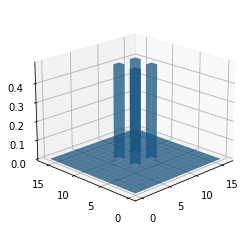

In [9]:
fig = plt.figure(facecolor='None')
ax = fig.add_subplot(111, projection='3d')
_x = np.arange(16)
_y = np.arange(16)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
zz=rob.ravel()
bottom = np.zeros_like(zz)
# Construct arrays with the dimensions for the 16 bars.
dx = dy = 1


ax.bar3d(x, y, bottom, dx, dy, zz, shade=True,alpha=0.5)
ax.azim = 225#240  # z rotation (default=270)
ax.elev = 20#10     # x rotation (default=0)
ax.set_facecolor("white")

In [14]:

df = pd.DataFrame(alist[4])
df.to_excel('corrfun4.xlsx')

In [7]:
df = pd.DataFrame(zzzzlist)

df.to_excel('zzzz.xlsx')

In [8]:
df = pd.DataFrame(roblist)
df.to_excel('rob.xlsx')

In [18]:
df = pd.DataFrame(Ilist)
df.to_excel('Icorner.xlsx')